In [7]:
%%time
# for development, changes in other modules have to be reloaded to reflect changes
%load_ext autoreload
%autoreload 1

import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import os, sys
import SimpleITK as sitk

%aimport config 
sys.path.append(config.lib_dir)
%aimport utils
%aimport segment 
%aimport match 
%aimport register 
%aimport evaluate 
%aimport qc 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.19 ms


In [2]:
img_file_names = [x for x in os.listdir(config.data_dir) if x[-4:] == '.tif']
parsed_names = pd.DataFrame([utils.parse_file_name(x) for x in img_file_names])
parsed_names2 = parsed_names[parsed_names.slide_name == config.slide_name]
parsed_names3 = parsed_names2[parsed_names2.scene == config.scene_name]
imgs = utils.load_imgs_mt(parsed_names3.original.values, config.data_dir, _type=sitk.sitkUInt16)

starting multithreaded image loading...
assigning threads...done.
waiting for threads to complete.
finished task: 48/50finished task: 26/50nished task: 10/50finished task: 29/50finished task: 21/50
threads complete.

...image loading complete.


In [39]:
def get_n_missing_cores(res, _eps, config):

    cluster_labels = match.match_cores_across_rounds(res, config=config, eps=_eps, verbose=False)
    res = res.assign(cluster = cluster_labels)

    num_of_rounds = parsed_names['round'].unique().shape[0]

    clust_sizes = {i:(cluster_labels==i).sum() for i in np.unique(cluster_labels)}
    missing_ = {k:np.abs(num_of_rounds - v) for k,v in clust_sizes.items() if v != num_of_rounds}
    extra_txt = {k:f'{(num_of_rounds - v)}' for k,v in clust_sizes.items() if v != num_of_rounds}
    
    _tot = 0
    for _cl in sorted(missing_): 
        _tot += missing_[_cl]

    return _tot

In [73]:
res = {'eps':[], 'seg_q':[], 'gaus_blur':[], 'min_obj':[], 'nwrong':[]}

for _seg_quant in np.linspace(0.65,0.75,10): 
    print(_seg_quant)
    for _gaus_blur in np.linspace(2000, 6000, 10): 
        print('\t', _gaus_blur)
        for _min_obj_sz in np.logspace(3, 6, 10): 
            print('\t\t', _min_obj_sz)
            config.core_seg_quantile = _seg_quant
            config.gaussian_blur_variance = _gaus_blur
            config.min_object_size = _min_obj_sz
            
            R0_dapi_name = parsed_names3[(parsed_names3.color_channel == 'c1') & (parsed_names3['round'] == 'R0')]
            R0_dapi_full = imgs[R0_dapi_name.original.item()]
            R0_dapi = R0_dapi_full[::config.downsample_proportion,::config.downsample_proportion]
            R0_dapi_stats, shape_stats = segment.segment_dapi_round(R0_dapi, plot=False, config=config)
            res_ = match.get_all_rounds_core_statistics(parsed_names3, imgs, verbose=False, config=config)

            for _db_eps in np.linspace(0.01, 0.35, 10):
                nwrong = get_n_missing_cores(res_, _db_eps, config=config)

                res['eps'].append(_db_eps)
                res['seg_q'].append(_seg_quant)
                res['gaus_blur'].append(_gaus_blur)
                res['min_obj'].append(_min_obj_sz)
                res['nwrong'].append(nwrong)
                
res = pd.DataFrame(res)
res.head()

0.65
	 2000.0
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 2444.4444444444443
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 2888.8888888888887
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 3333.3333333333335
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 3777.777777777778
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 4222.222222222223
		 

		 464158.8833612772
		 1000000.0
	 2888.8888888888887
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 3333.3333333333335
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 3777.777777777778
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 4222.222222222223
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 4666.666666666667
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.88336127

		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 3777.777777777778
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 4222.222222222223
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 4666.666666666667
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 5111.111111111111
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 215443.46900318822
		 464158.8833612772
		 1000000.0
	 5555.555555555556
		 1000.0
		 2154.4346900318847
		 4641.588833612777
		 10000.0
		 21544.346900318822
		 46415.888336127726
		 100000.0
		 21544

,eps,seg_q,gaus_blur,min_obj,nwrong
0,0.010000,0.65,2000.0,1000.0,330
1,0.047778,0.65,2000.0,1000.0,128
2,0.085556,0.65,2000.0,1000.0,114
3,0.123333,0.65,2000.0,1000.0,120
4,0.161111,0.65,2000.0,1000.0,124


In [74]:
res.sort_values(by='nwrong').head(25)

,eps,seg_q,gaus_blur,min_obj,nwrong
3123,0.123333,0.683333,2444.444444,4641.588834,30
3182,0.085556,0.683333,2444.444444,464158.883361,30
3173,0.123333,0.683333,2444.444444,215443.469003,30
3172,0.085556,0.683333,2444.444444,215443.469003,30
3163,0.123333,0.683333,2444.444444,100000.000000,30
3102,0.085556,0.683333,2444.444444,1000.000000,30
3103,0.123333,0.683333,2444.444444,1000.000000,30
3183,0.123333,0.683333,2444.444444,464158.883361,30
3162,0.085556,0.683333,2444.444444,100000.000000,30
3152,0.085556,0.683333,2444.444444,46415.888336,30


In [2]:
int( 4e4 / 10 )

4000

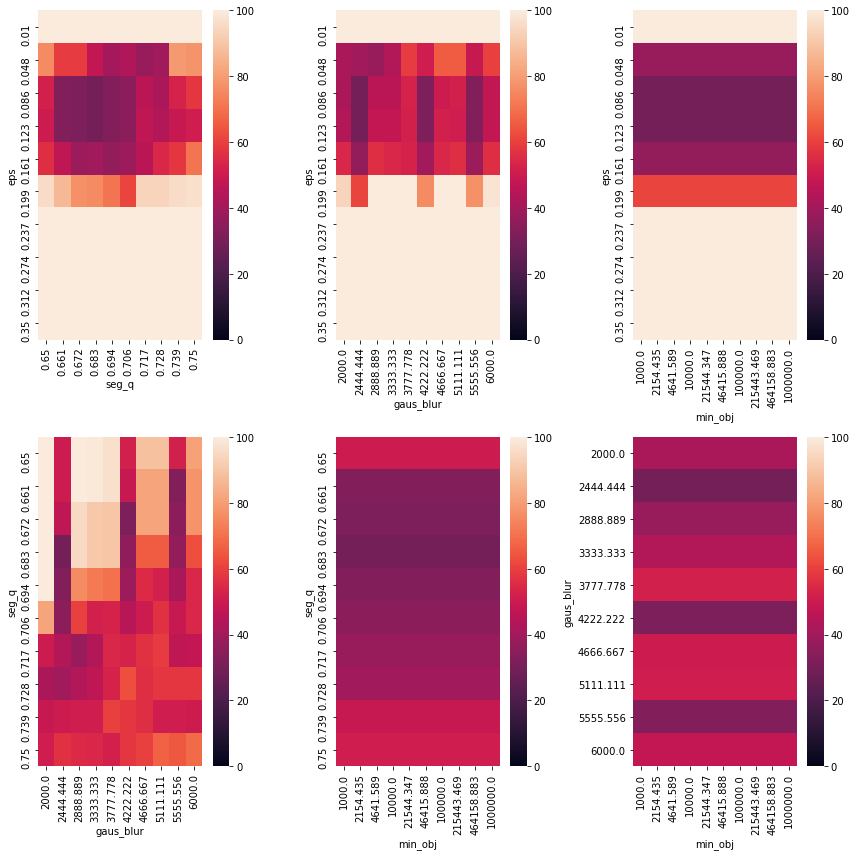

In [76]:
f, axes = plt.subplots(2,3, figsize=(12,12))

j=0
for i,feat1 in enumerate(['eps', 'seg_q', 'gaus_blur', 'min_obj']): 
    for feat2 in ['eps', 'seg_q', 'gaus_blur', 'min_obj'][(i+1):]:
        data = res[[feat1, feat2, 'nwrong']].drop_duplicates().round(3).pivot_table(index=feat1, columns=feat2, values='nwrong', aggfunc='min')
        sbn.heatmap(data, ax=axes.flat[j], vmin=0, vmax=100)
        j += 1
        
plt.tight_layout()
plt.show()

In [56]:
res2.isna().any()

eps          False
seg_q        False
gaus_blur    False
min_obj      False
nmissing     False
dtype: bool

In [57]:
?pd.DataFrame.pivot_table

In [4]:
def get_best_eps(res):
    num_of_rounds = parsed_names['round'].unique().shape[0]

    epss = []
    nright = []
    toomany = []
    toofew = []

    for _eps in np.arange(0.01, 0.35, 0.005): 
        try: 
            cluster_labels = match.match_cores_across_rounds(res, config=config, eps=_eps, verbose=False)

            uniq, labels = np.unique(cluster_labels + 1, return_counts=True)
            nright.append(np.unique(uniq[labels == num_of_rounds]).shape[0]) 
            toomany.append(np.unique(uniq[labels > num_of_rounds]).shape[0]) 
            toofew.append(np.unique(uniq[labels < num_of_rounds]).shape[0]) 
            epss.append(_eps)
        except: 
            print('failed eps:', _eps)
            raise
            
    return np.array(epss)[np.array(nright) == max(nright)]

In [5]:
ts = []
nmissing = []
for t in np.linspace(0.65,0.69,10): 
    ts.append(ts)
    print('-'*100)
    print('segmentation quantile threshold:', t)
    config.core_seg_quantile = t
    R0_dapi_name = parsed_names3[(parsed_names3.color_channel == 'c1') & (parsed_names3['round'] == 'R0')]
    R0_dapi_full = imgs[R0_dapi_name.original.item()]
    R0_dapi = R0_dapi_full[::config.downsample_proportion,::config.downsample_proportion]
    R0_dapi_stats, shape_stats = segment.segment_dapi_round(R0_dapi, plot=False, config=config)
    res = match.get_all_rounds_core_statistics(parsed_names3, imgs, verbose=False, config=config)
    cluster_labels = match.match_cores_across_rounds(res, config=config)
    res = res.assign(cluster = cluster_labels)
    best_eps = get_best_eps(res)
    print('best_eps (s):', best_eps)
    num_of_rounds = parsed_names['round'].unique().shape[0]

    clust_sizes = {i:(cluster_labels==i).sum() for i in np.unique(cluster_labels)}
    missing_ = {k:(num_of_rounds - v) for k,v in clust_sizes.items() if v != num_of_rounds}
    extra_txt = {k:f'{(num_of_rounds - v)}' for k,v in clust_sizes.items() if v != num_of_rounds}
    _tot = 0
    for _cl in sorted(missing_): 
        _tot += missing_[_cl]
    nmissing.append(_tot)
    print('Total number of missing cores:', _tot)
    print('-'*100)

#plt.figure()
#plt.plot(ts, nmissing, 'r.')
#plt.show()

----------------------------------------------------------------------------------------------------
segmentation quantile threshold: 0.65
using clustering method: dbscan
best_eps (s): [0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12  0.125
 0.13  0.135 0.14 ]
Total number of missing cores: 42
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
segmentation quantile threshold: 0.6544444444444445
using clustering method: dbscan
best_eps (s): [0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12  0.125
 0.13  0.135 0.14 ]
Total number of missing cores: 42
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
segmentation quantile threshold: 0.6588888888888889
using c

In [9]:
blurs = []
nmissing = []
print('quantile seg:', config.core_seg_quantile)
for blur in np.linspace(5000, 6000, 20): 
    blurs.append(blur)
    print('-'*100)
    print('gaussian blur', blur)
    config.gaussian_blur_variance = blur
    
    R0_dapi_name = parsed_names3[(parsed_names3.color_channel == 'c1') & (parsed_names3['round'] == 'R0')]
    R0_dapi_full = imgs[R0_dapi_name.original.item()]
    R0_dapi = R0_dapi_full[::config.downsample_proportion,::config.downsample_proportion]
    R0_dapi_stats, shape_stats = segment.segment_dapi_round(R0_dapi, plot=False, config=config)
    res = match.get_all_rounds_core_statistics(parsed_names3, imgs, verbose=False, config=config)
    cluster_labels = match.match_cores_across_rounds(res, config=config)
    res = res.assign(cluster = cluster_labels)
    best_eps = get_best_eps(res)
    print('best_eps (s):', best_eps)
    num_of_rounds = parsed_names['round'].unique().shape[0]

    clust_sizes = {i:(cluster_labels==i).sum() for i in np.unique(cluster_labels)}
    missing_ = {k:(num_of_rounds - v) for k,v in clust_sizes.items() if v != num_of_rounds}
    extra_txt = {k:f'{(num_of_rounds - v)}' for k,v in clust_sizes.items() if v != num_of_rounds}
    _tot = 0
    for _cl in sorted(missing_): 
        _tot += missing_[_cl]
    nmissing.append(_tot)

    print('Total number of missing cores:', _tot)
    print('-'*100)

#plt.figure()
#plt.plot(blurs, nmissing, 'r.')
#plt.show()

quantile seg: 0.68
----------------------------------------------------------------------------------------------------
gaussian blur 5000.0
using clustering method: dbscan
best_eps (s): [0.04  0.045 0.05  0.055 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095
 0.1   0.105 0.11  0.115 0.12  0.125 0.13 ]
Total number of missing cores: 52
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
gaussian blur 5052.631578947368
using clustering method: dbscan
best_eps (s): [0.04  0.045 0.05  0.055 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095
 0.1   0.105 0.11  0.115 0.12  0.125 0.13 ]
Total number of missing cores: 52
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
gaussian blur 5105.2631578947

using clustering method: dbscan
best_eps (s): [0.04  0.045 0.05  0.055 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095
 0.1   0.105 0.11  0.115 0.12  0.125 0.13  0.135 0.14 ]
Total number of missing cores: 43
----------------------------------------------------------------------------------------------------


In [ ]:
print('quantile seg:', config.core_seg_quantile)
for t in np.linspace(3e4, 5e4, 10): 
    print('-'*100)
    mos = int( t / config.downsample_proportion )
    print('min object size:', mos)
    config.min_object_size = mos
    
    R0_dapi_name = parsed_names3[(parsed_names3.color_channel == 'c1') & (parsed_names3['round'] == 'R0')]
    R0_dapi_full = imgs[R0_dapi_name.original.item()]
    R0_dapi = R0_dapi_full[::config.downsample_proportion,::config.downsample_proportion]
    R0_dapi_stats, shape_stats = segment.segment_dapi_round(R0_dapi, plot=False, config=config)
    res = match.get_all_rounds_core_statistics(parsed_names3, imgs, verbose=False, config=config)
    cluster_labels = match.match_cores_across_rounds(res, config=config)
    res = res.assign(cluster = cluster_labels)
    best_eps = get_best_eps(res)
    print('best_eps (s):', best_eps)
    num_of_rounds = parsed_names['round'].unique().shape[0]

    clust_sizes = {i:(cluster_labels==i).sum() for i in np.unique(cluster_labels)}
    missing_ = {k:(num_of_rounds - v) for k,v in clust_sizes.items() if v != num_of_rounds}
    extra_txt = {k:f'{(num_of_rounds - v)}' for k,v in clust_sizes.items() if v != num_of_rounds}
    _tot = 0
    for _cl in sorted(missing_): 
        _tot += missing_[_cl]

    print('Total number of missing cores:', _tot)
    print('-'*100)